In [35]:
#### Ejercicio 1 ###

import requests
from requests_html import HTMLSession
from requests_html import HTML    
import pandas as pd
import re


def abs_sub (sess, url):
    r = sess.get(url)
    abstract = r.html.find("blockquote[class ='abstract mathjax']", first=True).text
    submitted = r.html.find("div[class= 'dateline']", first = True).text
    
    abstract, *_ =re.findall("(?<=Abstract\: ),*", abstract)
    submitted, *_ =re.findall("(?<= on ).*(?=\))", submitted)
    
    return abstract, submitted


In [37]:


url = "https://arxiv.org/list/stat.ML/recent"
with HTMLSession() as sess:
    r = sess.get(url)

divpage = r.html.find("div[id='dlpage']", first=True)    
    
papers_links = divpage.find("dt")
papers_titles = divpage.find("dd")

#Se crea la tabla    
values = []
for link_secc, title_secc in zip(papers_links, papers_titles):
    title = title_secc.find("div[class='list-title mathjax']", first=True).text
    
    abstract_url = link_secc.find("a[title='Abstract']", first=True).absolute_links
    abstract_url, *_ = abstract_url
    
    abstract, submitted = abs_sub(sess, abstract_url)
    
    values.append([title, abstract_url, abstract, submitted])

df_values = pd.DataFrame(values, columns=["title", "url", "abstract", "submitted"])

# Depuramos el dataframe eliminando la palabra "Title"
df_values = df_values.assign(title=df_values.title.str.lstrip("Title: "))

In [38]:
df_values.head()

,title,url,abstract,submitted
0,Self-Tuning Deep Reinforcement Learning,https://arxiv.org/abs/2002.12928,,28 Feb 2020
1,he estimation error of general first order met...,https://arxiv.org/abs/2002.12903,,28 Feb 2020
2,Generalizing Convolutional Neural Networks for...,https://arxiv.org/abs/2002.12880,,25 Feb 2020
3,A Deep Generative Model for Fragment-Based Mol...,https://arxiv.org/abs/2002.12826,,28 Feb 2020
4,Risk Bounds for Multi-layer Perceptrons throug...,https://arxiv.org/abs/2002.12640,,28 Feb 2020


In [69]:
### Ejercicio 2 ###

import os
import requests
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from alpha_vantage.foreignexchange import ForeignExchange

url = "https://www.alphavantage.co"
base_url = "https://www.alphavantage.co/query"

from alpha_vantage.foreignexchange import ForeignExchange

avkey = os.environ["ALPHA_VANTAGE_KEY"] = "GGNNS3SVY76A7NUV"

#fx = ForeignExchange(key=avkey, output_format="pandas")
#data, metadata = fx.get_currency_exchange_daily( "MXN", "EUR", "BRL", "ARS", "CHF")

def divisa (avkey, currency, base_url):
    daily = {
        "function": "FX_DAILY",
        "to_symbol": "USD",
        "from_symbol": currency,
        "apikey": avkey,
        "outputsize": "full",
    }

    r = requests.get(base_url, params=daily)

    data = r. json()
    
    price = defaultdict(dict)
    
    for key, values in data["Time Series FX (Daily)"].items():
        price[key] = values['4. close']
    return price

currency_list = ["MXN", "EUR", "BRL", "ARS", "CHF"]
c_price = defaultdict(dict)

for currency in currency_list:
    data = divisa(avkey, currency, base_url)
    c_price[currency]=data
    
df_data = pd.DataFrame(c_price, dtype= float).dropna().sort_index()

In [64]:
df_data.head()

,MXN,EUR,BRL,ARS,CHF
2014-11-07,0.0737,1.2454,0.3902,0.1170,1.0341
2014-11-09,0.0738,1.2462,0.3894,0.1170,1.0359
2014-11-10,0.0734,1.2424,0.3933,0.1170,1.0328
2014-11-11,0.0735,1.2473,0.3894,0.1170,1.0364
2014-11-12,0.0737,1.2428,0.3890,0.1170,1.0337


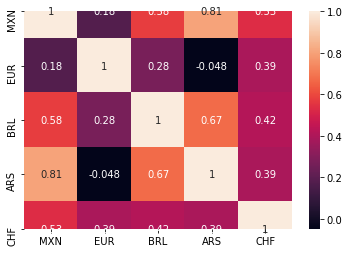

In [70]:
### Ejercicio 3 ###

import seaborn as sns

sns.heatmap(df_data.corr(), annot = True)

In [72]:
#### Ejercicio 4 ####

vent= df_data.rolling(30).corr().dropna()
vent.head()

MXN       EUR       BRL       ARS       CHF
2014-12-10 MXN  1.000000  0.687213  0.325804  0.974887  0.685253
           EUR  0.687213  1.000000  0.015035  0.619399  0.995422
           BRL  0.325804  0.015035  1.000000  0.283967 -0.010822
           ARS  0.974887  0.619399  0.283967  1.000000  0.619416
           CHF  0.685253  0.995422 -0.010822  0.619416  1.000000

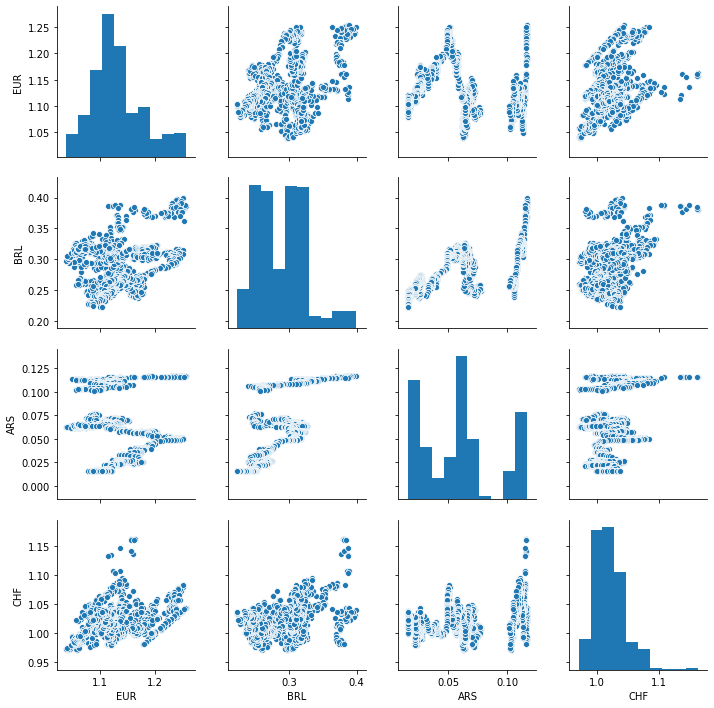

In [74]:
#### Ejercicio 5 ####

sns.pairplot(df_data, vars =["EUR", "BRL", "ARS", "CHF"])